In [1]:
# read data

import pandas as pd

add_100 = pd.read_csv('data/addresses-with-balance-≥-100-btc-24h.csv')
add_100['timestamp'] = add_100['timestamp'].str.split('T', expand=True)[0]
add_100.set_index('timestamp', inplace=True)
add_100.columns = ['≥0.1k']

add_1k = pd.read_csv('data/addresses-with-balance-≥-1-k-btc-24h.csv')
add_1k['timestamp'] = add_1k['timestamp'].str.split('T', expand=True)[0]
add_1k.set_index('timestamp', inplace=True)
add_1k.columns = ['≥1k']

add_10k = pd.read_csv('data/addresses-with-balance-≥-10-k-btc-24h.csv')
add_10k['timestamp'] = add_10k['timestamp'].str.split('T', expand=True)[0]
add_10k.set_index('timestamp', inplace=True)
add_10k.columns = ['≥10k']

data = add_100.join(add_1k, on='timestamp').join(add_10k, on='timestamp')


In [2]:
# define fit function: log, exponent, power

def func1(x, a, b):
    return a * np.log(x) + b


def func2(x, a, b, c):
    return a * np.exp(-b * x) + c


def func3(x, a, b, c):
    return a * (x ** b) + c


In [3]:
# Use log function to fit

from scipy.optimize import curve_fit
import numpy as np

res1 = pd.DataFrame(columns=('a', 'b', 'R^2'))
x = [100, 1000, 10000]

for i in range(len(data)):
    y = data.iloc[i].to_list()
    popt, pcov = curve_fit(func1, x, y)
    y_pre = [func1(i, popt[0], popt[1]) for i in x]
    y_bar = np.sum(y) / len(y)
    ssreg = np.sum((y_pre - y_bar) ** 2)
    sstot = np.sum((y - y_bar) ** 2)

    new = pd.DataFrame({'a': popt[0],
                        'b': popt[1],
                        'R^2': ssreg / sstot},
                       index=[0])

    res1 = res1.append(new)

res1.index = data.index


C:\Users\zwlie\anaconda3\envs\weather\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


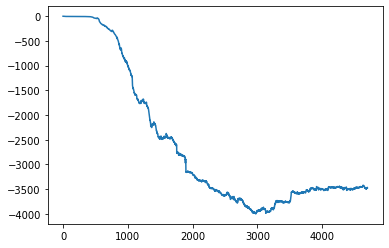

In [4]:
# plot of coef: a

import matplotlib.pyplot as plt

plt.plot(list(range(len(res1['a']))), res1['a'].to_list())
plt.show()


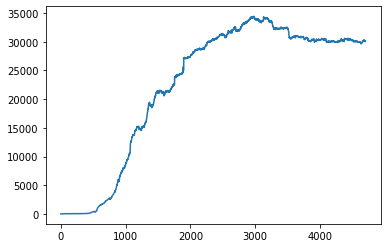

In [5]:
# plot of coef: b

plt.plot(list(range(len(res1['b']))), res1['b'].to_list())
plt.show()


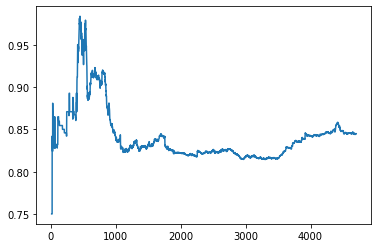

In [6]:
# plot of coef: R^2

plt.plot(list(range(len(res1['R^2']))), res1['R^2'].to_list())
plt.show()


In [19]:
# function to estimate quantity held by whales

from scipy.integrate import quad

def quantity_whale(threshold, y, coef):
    x = [100, 1000, 10000]
    y_pre = [func1(i, coef[0], coef[1]) for i in x]
    y_bar = np.sum(y) / len(y)
    ssreg = np.sum((y_pre - y_bar) ** 2)
    sstot = np.sum((y - y_bar) ** 2)
#     print('R^2: ', ssreg / sstot)
    x0 = np.exp(-coef[1] / coef[0])
#     print("Max: {}".format(x0))
#     plt.plot(x, y_pre, 'r--')
#     plt.plot(x, y, 'b-')
    plt.show()

    if (threshold < x0):
        quantity = quad(func1, threshold, x0, args=coef)
#         print('quantity: ', quantity[0])
        return quantity[0]
    else:
#         print("Few addresses holds more than {}".format(threshold))
        return 0


R^2:  0.8445335368479626
Max: 5797.464957299289


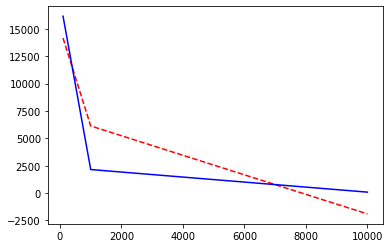

quantity:  200839.21424655244


In [8]:
date = '2021-11-01'
coef = (res1.loc[date][0], res1.loc[date][1])
q = quantity_whale(5000, data.loc[date], coef)


R^2:  0.8448435683461654
Max: 5805.427120746783


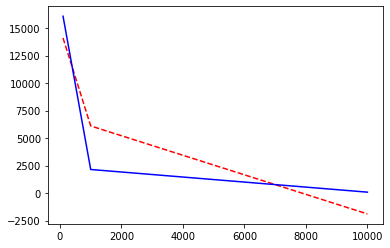

Few addresses holds more than 5900


In [9]:
date = '2021-11-17'
coef = (res1.loc[date][0], res1.loc[date][1])
q = quantity_whale(5900, data.loc[date], coef)


In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_whale_change(data, threshold, days1, days2):
    dates = data.index.to_list()
    wh = [quantity_whale(threshold, data.loc[d], (res1.loc[d][0], res1.loc[d][1])) for d in dates]
    wh_change = [np.mean(wh[i - (days1 - 1):i + 1]) - np.mean(wh[i - (days2 - 1):i + 1]) for i in range(days2 - 1, len(wh))]
    whales = pd.DataFrame(columns=['date', 'whales_change', 'whales'])
    whales['date'] = dates[days2 - 1:]
    whales['whales_change'] = wh_change
    whales['whales'] = wh[days2 - 1:]

    btc_usdt = pd.read_csv("./data/BTC-USDT.csv")
    btc_usdt = btc_usdt.sort_values(by="time")
    btc_usdt["price"] = btc_usdt["close"].to_numpy()
    btc_usdt[['date', 'time']] = btc_usdt['time'].str.split(' ', expand=True)
    btc_usdt = btc_usdt[["date", "time", "price"]]
    btc_usdt = btc_usdt[btc_usdt["time"] == "23:00:00"]
    btc_usdt = btc_usdt[['date', 'price']]

    whales = whales[whales['date'] >= '2019-10-01']
    btc_usdt = btc_usdt[btc_usdt['date'] <= '2021-11-17']

    trace0 = go.Scatter(x=whales['date'], y=whales['whales_change'], name='whales_change')
    trace1 = go.Scatter(x=btc_usdt['date'], y=btc_usdt['price'], name='price')

    fig = make_subplots()
    fig.add_trace(trace0)
    fig.add_trace(trace1)
    fig.show()


In [28]:
plot_whale_change(data, 5000, 7 ,14)

C:\Users\zwlie\anaconda3\envs\weather\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

invalid value encountered in double_scalars



In [29]:
plot_whale_change(data, 500, 7 ,14)

C:\Users\zwlie\anaconda3\envs\weather\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

invalid value encountered in double_scalars



In [30]:
plot_whale_change(data, 5000, 14 ,28)

C:\Users\zwlie\anaconda3\envs\weather\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

invalid value encountered in double_scalars

